In [123]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import mplfinance as mpf

# Stable-Baselines3 imports
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv  # Use this instead of DummyVecEnv

# Gymnasium (updated from Gym)
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box


In [115]:
# Load Data
df = pd.read_csv("MGOL_data.xml.csv")  # Replace with actual file
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')
df.set_index('datetime', inplace=True)

In [116]:
df.index = df.index + pd.Timedelta(hours=3)
df.index.name = 'Date'
df = df.drop(columns=['symbol', 'frame'])

In [195]:
from stable_baselines3.common.policies import ActorCriticPolicy
import torch
import torch.nn as nn

class MaskedActorCriticPolicy(ActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super(MaskedActorCriticPolicy, self).__init__(*args, **kwargs)

    def forward(self, obs, deterministic=False):
        # Extract features from the observation
        features = self.extract_features(obs)
        
        # Apply the action mask
        action_mask = obs[:, -self.action_space.n:]  # Assume the last n elements are the action mask
        logits = self.action_net(features)
        masked_logits = logits * action_mask  # Mask invalid actions
        
        # Sample actions
        if deterministic:
            actions = torch.argmax(masked_logits, dim=1)
        else:
            actions = torch.distributions.Categorical(logits=masked_logits).sample()
        
        # Compute values and log probabilities
        values = self.value_net(features)
        log_probs = torch.distributions.Categorical(logits=masked_logits).log_prob(actions)
        
        return actions, values, log_probs

In [190]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn

class CustomFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=64):
        super(CustomFeatureExtractor, self).__init__(observation_space, features_dim)
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 64),  # Input size: 9, Output size: 64
            nn.ReLU(),
            nn.Linear(64, 64),  # Hidden layer
            nn.ReLU(),
        )

    def forward(self, observations):
        return self.net(observations)

# Define the custom policy
from stable_baselines3 import PPO

policy_kwargs = dict(
    features_extractor_class=CustomFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=64),
)


In [191]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gym import Env
from gym.spaces import Discrete, Box

class TradingEnv(Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.balance = 10000  # Starting cash
        self.shares = 0
        self.total_reward = 0
        self.position_open = False  # Track open positions
        self.round_trip_trades = 0  # Counter for buy-sell cycles

        # Action Space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = Discrete(3)

        # Observation Space: Open, High, Low, Close, Volume
        #self.observation_space = Box(
        #    low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        #)
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(9,), dtype=np.float32
        )
    
    def get_valid_actions(self):
        valid_actions = [0]  # Hold is always valid
        if not self.position_open:  # Allow Buy only if no position is open
            valid_actions.append(1)
        if self.position_open:  # Allow Sell only if a position is open
            valid_actions.append(2)
        return valid_actions

    def get_obs(self):
        # Include the current position and valid actions in the observation
        position = [1] if self.position_open else [0]  # Shape: (1,)
        valid_actions = self.get_valid_actions()
        action_mask = [1 if i in valid_actions else 0 for i in range(self.action_space.n)]  # Shape: (3,)
        
        # Combine all features into a single observation array
        obs = np.concatenate([
            self.df.iloc[self.current_step][["open", "high", "low", "close", "volume"]].values,  # Shape: (5,)
            position,  # Shape: (1,)
            action_mask  # Shape: (3,)
        ])
        
        return obs
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = 10000
        self.shares = 0
        self.position_open = False
        self.round_trip_trades = 0
        obs = self.get_obs()  # Use the updated observation method
        return obs, {}

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return np.zeros(self.observation_space.shape), 0, True, False, {}
    
        current_price = self.df.iloc[self.current_step]["close"]
        reward = 0
        done = False
        truncated = False
    
        valid_actions = self.get_valid_actions()
        if action not in valid_actions:
            reward = -1000  # Large penalty for invalid action
        else:
            if action == 1:  # Buy
                self.shares = 1
                self.balance -= current_price
                self.position_open = True
                reward = -0.01  # Small penalty to avoid random buying
                self.round_trip_trades += 1
    
            elif action == 2:  # Sell
                self.shares = 0
                self.balance += current_price
                reward = (current_price - self.df.iloc[self.current_step - 1]['close'])*100  # Reward profit
                self.position_open = False
    
            else:  # Hold
                reward -= 0.005  # Small penalty for holding
    
        # Terminate after 10 round-trip trades or end of data
        if self.round_trip_trades >= 10:
            done = True
        if self.current_step >= len(self.df) - 1:
            done = True
    
        self.current_step += 1
        obs = self.get_obs()  # Use the updated observation method
        info = {"valid_actions": valid_actions}  # Include valid actions in info for debugging
    
        return obs, reward, done, truncated, info

In [15]:
import pandas as pd
import numpy as np
from gym import Env
from gym.spaces import Discrete, Box

# Load Data
df = pd.read_csv("MGOL_data.xml.csv")  # Replace with actual file
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')
df.set_index('datetime', inplace=True)

# Custom Trading Environment
class TradingEnv(Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.balance = 10000  # Starting cash
        self.shares = 0
        self.total_reward = 0

        # Action Space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = Discrete(3)

        # Observation Space: Open, High, Low, Close, Volume
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['close']  # Use correct column name
        reward = 0
        done = False
        truncated = False  # Gym v0.26+ requires `truncated` in addition to `done`

        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares += 1
                self.balance -= current_price
        elif action == 2:  # Sell
            if self.shares > 0:
                self.shares -= 1
                self.balance += current_price
                reward = current_price - self.df.iloc[self.current_step - 1]['close']  # Use correct column name

        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True  # End of data

        # Get the next observation
        obs = self.df.iloc[self.current_step][['open', 'high', 'low', 'close', 'volume']].values  # Use correct column names
        info = {}  # Additional info (can be used for debugging or logging)

        return obs, reward, done, truncated, info  # Gym v0.26+ requires 5 return values

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Required for Gym v0.26+
        self.current_step = 0
        self.balance = 10000
        self.shares = 0
        observation = self.df.iloc[self.current_step][['open', 'high', 'low', 'close', 'volume']].values  # Use correct column names
        info = {}  # Return an empty info dictionary
        return observation, info

In [192]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv
import pandas as pd

# Initialize the environment and model
env = TradingEnv(df)  # Replace `TradingEnv` with your custom environment
env = DummyVecEnv([lambda: env])  # Wrap the environment for vectorized operations


# Initialize the model with the custom policy
model = PPO(
    policy=MaskedActorCriticPolicy,#"MlpPolicy",
    env=env,
    verbose=1,
    policy_kwargs=policy_kwargs,  # Use the custom policy
    learning_rate=3e-4,
    n_steps=min(len(df) // 2, 512),
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    max_grad_norm=0.5,
)

Using cpu device


/Users/larka/jupyter_env/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/larka/jupyter_env/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 480`, after every 7 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=480 and n_envs=1)
  warnings.warn(


In [193]:
def simulate_trades(model, env):
    obs = env.reset()
    done = False
    while not done:
        # Predict action
        action, _ = model.predict(obs)
        
        # Take action in the environment
        obs, reward, done, info = env.step(action)
        
        # Access valid_actions from the info dictionary
        valid_actions = info[0].get("valid_actions", [0, 1, 2])  # Access the first element of the list
        
        # Print debug information
        print(f"Action: {action}, Reward: {reward}, Done: {done}, Valid Actions: {valid_actions}")

# Simulate trades
simulate_trades(model, env)

Action: [2], Reward: [-1000.], Done: [False], Valid Actions: [0, 1]
Action: [0], Reward: [-0.005], Done: [False], Valid Actions: [0, 1]
Action: [1], Reward: [-0.01], Done: [False], Valid Actions: [0, 1]
Action: [0], Reward: [-0.005], Done: [False], Valid Actions: [0, 2]
Action: [1], Reward: [-1000.], Done: [False], Valid Actions: [0, 2]
Action: [2], Reward: [-1.13], Done: [False], Valid Actions: [0, 2]
Action: [1], Reward: [-0.01], Done: [False], Valid Actions: [0, 1]
Action: [1], Reward: [-1000.], Done: [False], Valid Actions: [0, 2]
Action: [0], Reward: [-0.005], Done: [False], Valid Actions: [0, 2]
Action: [1], Reward: [-1000.], Done: [False], Valid Actions: [0, 2]
Action: [0], Reward: [-0.005], Done: [False], Valid Actions: [0, 2]
Action: [2], Reward: [-0.04], Done: [False], Valid Actions: [0, 2]
Action: [1], Reward: [-0.01], Done: [False], Valid Actions: [0, 1]
Action: [2], Reward: [-0.2], Done: [False], Valid Actions: [0, 2]
Action: [2], Reward: [-1000.], Done: [False], Valid Act

In [194]:
def predict_with_masking(model, env):
    obs = env.reset()
    done = False
    while not done:
        # Predict action
        action, _ = model.predict(obs)
        
        # Take action in the environment
        obs, reward, done, info = env.step(action)
        
        # Access valid_actions from the info dictionary
        valid_actions = info[0].get("valid_actions", [0, 1, 2])  # Default to all actions if not found
        
        # Print debug information
        print(f"Action: {action}, Reward: {reward}, Done: {done}, Valid Actions: {valid_actions}")

def train_model(num_timesteps, model_name):
    """
    Train the model for a specified number of timesteps and save it.

    Args:
        num_timesteps (int): Number of timesteps to train the model.
        model_name (str): Name of the file to save the trained model.
    """
    # Train the model
    model.learn(total_timesteps=num_timesteps)

    # Save the trained model
    model.save(model_name)
    print(f"Model trained for {num_timesteps} timesteps and saved as {model_name}")

def record_signals(model_name, buy_signals_list, sell_signals_list):
    """
    Load a trained model, simulate trades, and record buy/sell signals.

    Args:
        model_name (str): Name of the file to load the trained model from.
        buy_signals_list (list): List to store buy signals.
        sell_signals_list (list): List to store sell signals.
    """
    # Load the trained model
    model = PPO.load(model_name)

    # Reset the environment
    obs = env.reset()
    done = False

    # Simulate trades
    while not done:
        # Get valid actions from the environment
        valid_actions = env.get_attr("valid_actions")[0]  # Access valid_actions from the environment

        # Predict action with masking
        action, _ = model.predict(obs, action_masks=[valid_actions])
        action = action[0]  # Extract the action from the batch (DummyVecEnv)

        # Record buy or sell signals
        current_step = env.get_attr('current_step')[0]  # Get the current step index
        if action == 1:  # Buy signal
            buy_signals_list.append(df.index[current_step])
        elif action == 2:  # Sell signal
            sell_signals_list.append(df.index[current_step])

        # Take action in the environment
        obs, reward, done, info = env.step([action])  # Step through the environment

        # Print debug information
        print(f"Action: {action}, Reward: {reward}, Done: {done}, Valid Actions: {valid_actions}")

        # End the episode if done
        if done:
            break

    print(f"Signals recorded for model: {model_name}")

# Initialize lists to store buy and sell signals
buy_signals_1000 = []
sell_signals_1000 = []
buy_signals_10000 = []
sell_signals_10000 = []
buy_signals_100000 = []
sell_signals_100000 = []

# Train and save models
train_model(1000, "ppo_model_1000")
train_model(10000, "ppo_model_10000")
train_model(100000, "ppo_model_100000")

# Record signals for each model using predict_with_masking
print("Recording signals for ppo_model_1000")
predict_with_masking(PPO.load("ppo_model_1000"), env)

print("Recording signals for ppo_model_10000")
predict_with_masking(PPO.load("ppo_model_10000"), env)

print("Recording signals for ppo_model_100000")
predict_with_masking(PPO.load("ppo_model_100000"), env)

ValueError: not enough values to unpack (expected 3, got 1)

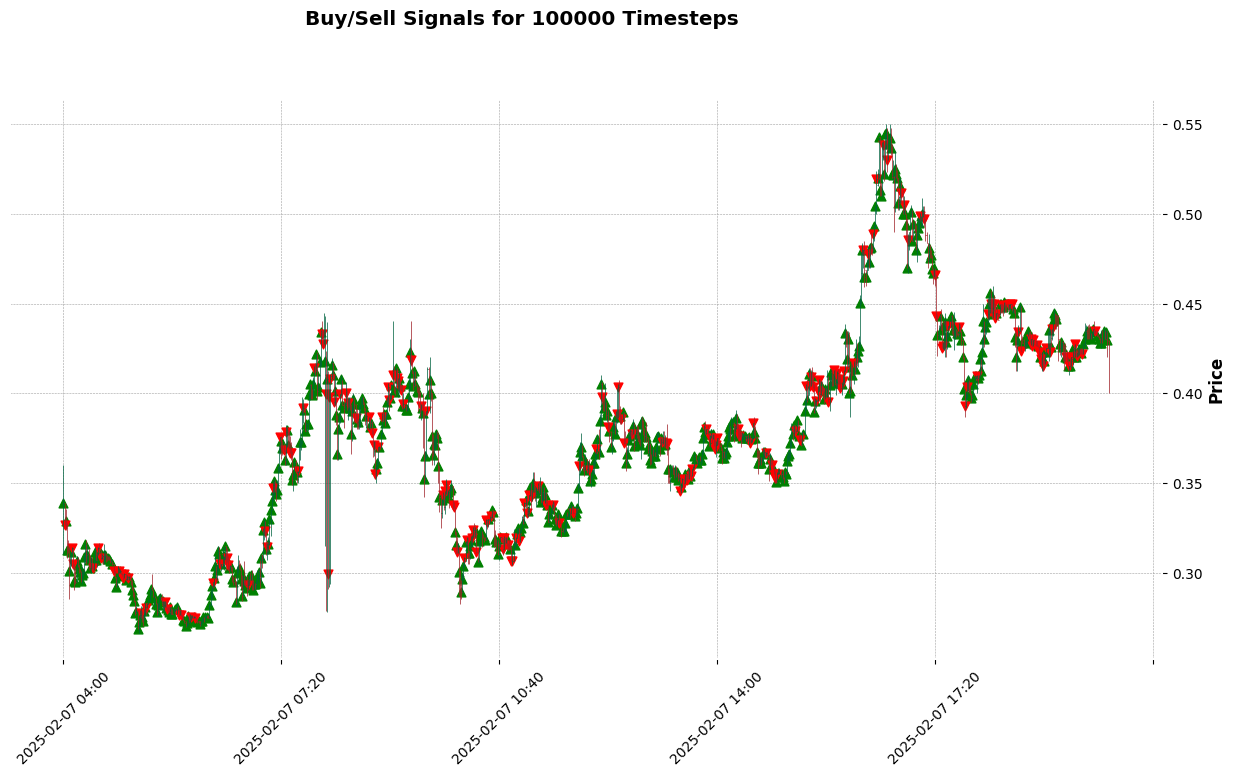

In [46]:
import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, buy_signals_1000, sell_signals_1000, buy_signals_10000, and sell_signals_10000 are your lists of timestamps

# Function to plot the signals for a given buy and sell signal list
def plot_signals(buy_signals, sell_signals, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df['close'].copy()
    buy_signal_prices[~df.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN
    
    sell_signal_prices = df['close'].copy()
    sell_signal_prices[~df.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df,
        type='ohlc',
        style='charles',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(16, 8),
        warn_too_much_data=10000,
        title=title #Adjust the size again to maintain consistency
    )

    #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add legend manually
    #plt.legend(['Buy Signals', 'Sell Signals'], loc='upper left')

    # Add title
    #plt.title(title)

    # Show the plot
    #plt.show()

# Plot for 1000 timesteps signals
plot_signals(buy_signals_1000, sell_signals_1000, title="Buy/Sell Signals for 1000 Timesteps")

# Plot for 10000 timesteps signals
plot_signals(buy_signals_10000, sell_signals_10000, title="Buy/Sell Signals for 10000 Timesteps")

# Plot for 100000 timesteps signals
#plot_signals(buy_signals_100000, sell_signals_100000, title="Buy/Sell Signals for 100000 Timesteps")


Total Profit for Profit for 1000 Timesteps: 0.03
Total Profit for Profit for 10000 Timesteps: -0.14
Total Profit for Profit for 100000 Timesteps: -0.11
Total Profit for 1000 Timesteps: 0.03
Total Profit for 10000 Timesteps: -0.14
Total Profit for 100000 Timesteps: -0.11


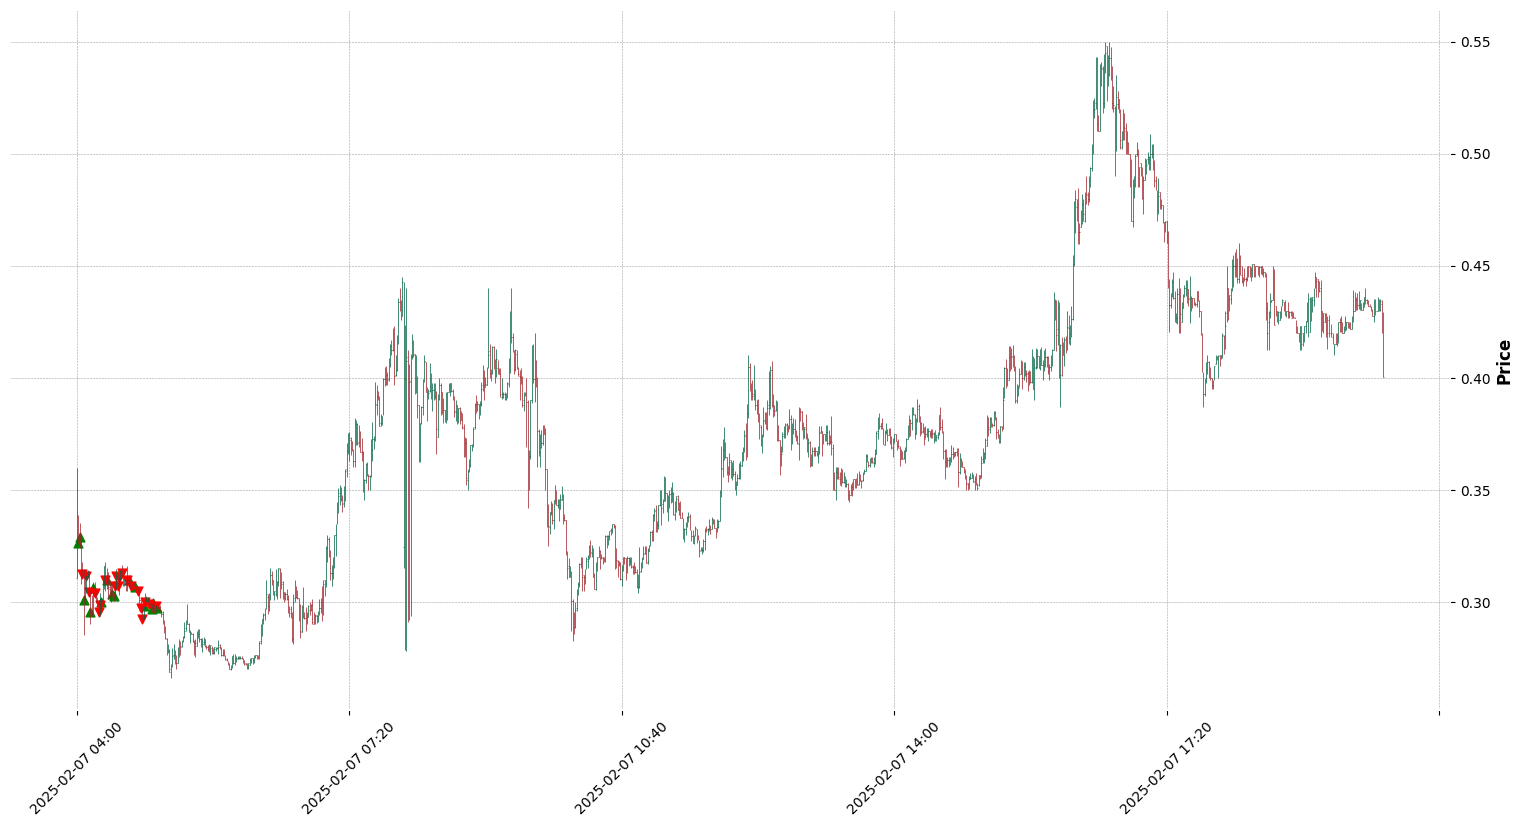

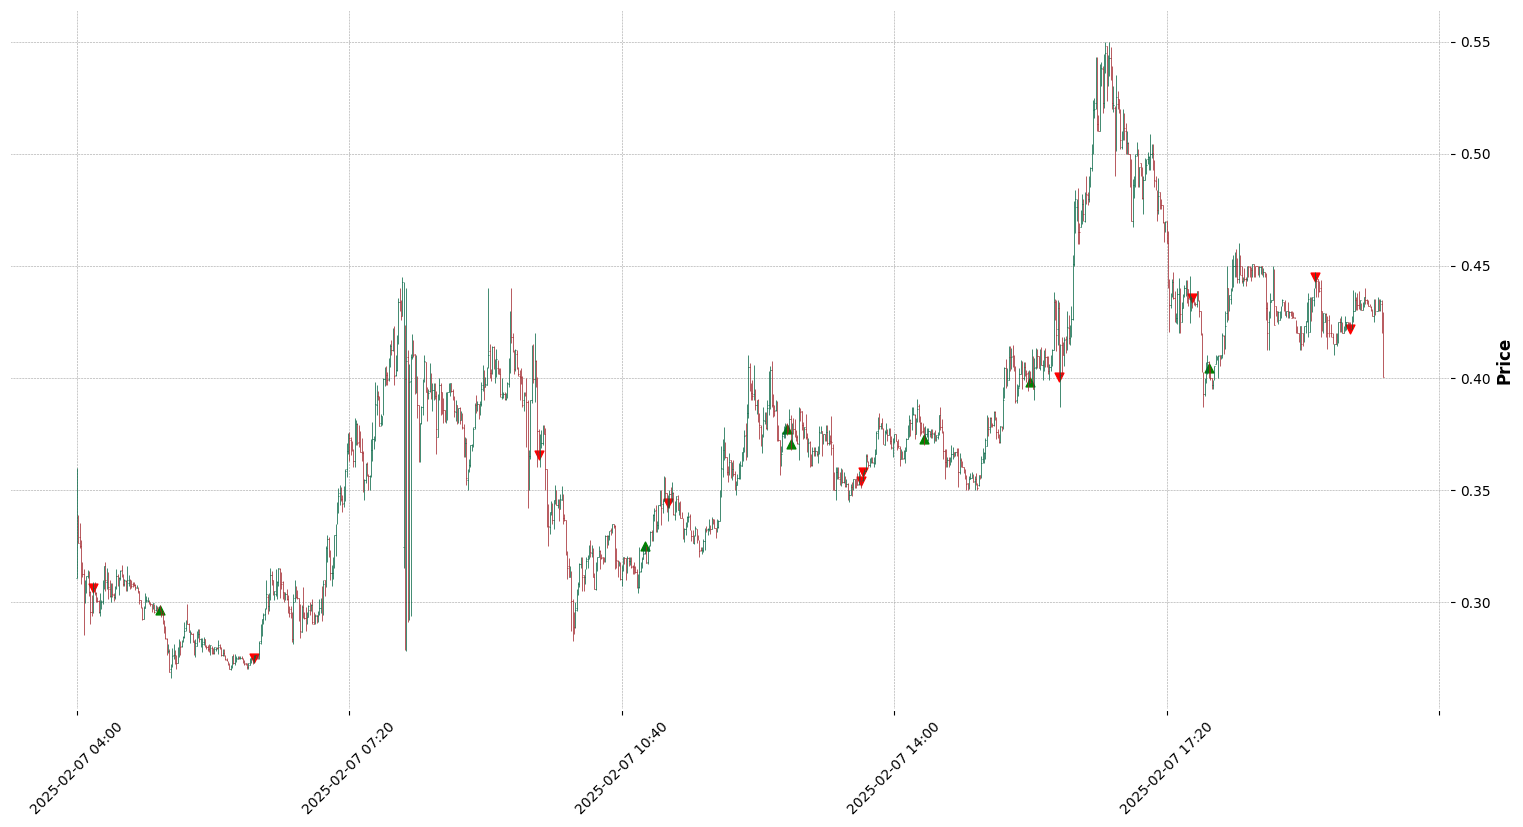

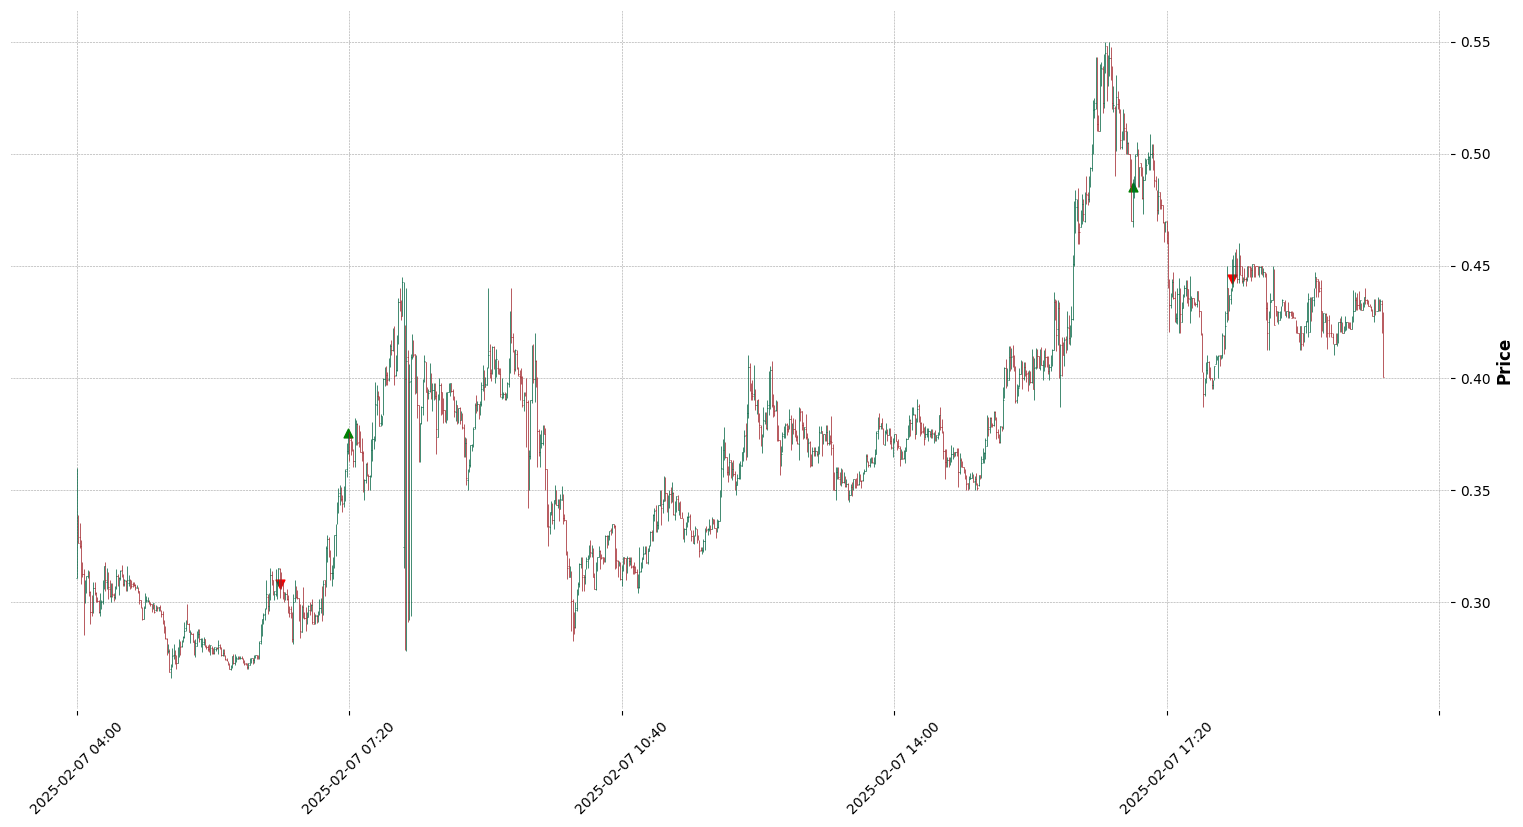

In [159]:
import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate profit based on buy and sell signals
def calculate_profit(buy_signals, sell_signals, df):
    buy_prices = df.loc[buy_signals, 'close']
    sell_prices = df.loc[sell_signals, 'close']

    # Ensure that the number of buy signals is less than or equal to the number of sell signals
    min_length = min(len(buy_prices), len(sell_prices))

    # Calculate profit for each pair of buy and sell signals
    profits = []
    for i in range(min_length):
        profit = sell_prices.iloc[i] - buy_prices.iloc[i]  # Profit = Sell Price - Buy Price
        profits.append(profit)

    total_profit = sum(profits)
    return total_profit, profits

# Function to plot the signals and compare profits
def plot_signals_and_compare_profit(buy_signals, sell_signals, df, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df['close'].copy()
    buy_signal_prices[~df.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN

    sell_signal_prices = df['close'].copy()
    sell_signal_prices[~df.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df,
        type='ohlc',
        style='charles',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(20, 10),
        warn_too_much_data=1000  # Adjust the size again to maintain consistency
    )

    # Customize x-axis
    #axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add legend manually
    #plt.legend(['Buy Signals', 'Sell Signals'], loc='upper left')

    # Add title
    #plt.title(title)

    # Show the plot
    #plt.show()

    # Calculate and print profit for the signals
    total_profit, profits = calculate_profit(buy_signals, sell_signals, df)
    print(f"Total Profit for {title}: {total_profit:.2f}")
    return total_profit

# Calculate and plot for 1000 timesteps signals
profit_1000 = plot_signals_and_compare_profit(buy_signals_1000, sell_signals_1000, df, title="Profit for 1000 Timesteps")

# Calculate and plot for 10000 timesteps signals
profit_10000 = plot_signals_and_compare_profit(buy_signals_10000, sell_signals_10000, df, title="Profit for 10000 Timesteps")

# Calculate and plot for 100000 timesteps signals
profit_100000 = plot_signals_and_compare_profit(buy_signals_100000, sell_signals_100000, df, title="Profit for 100000 Timesteps")


# Compare the total profits
print(f"Total Profit for 1000 Timesteps: {profit_1000:.2f}")
print(f"Total Profit for 10000 Timesteps: {profit_10000:.2f}")
print(f"Total Profit for 100000 Timesteps: {profit_100000:.2f}")